# Link labeldata to window cut-outs

In [1]:
# %pip install rioxarray
# %pip install geopandas

In [2]:
import numpy as np
import rasterio
from rasterio.features import shapes, geometry_mask
import rioxarray
import json

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'S2_comp_first.tif'
# labName = 'S2_20190131_-100p7_-75p0.geojson'
labName = 'output.geojson'

## Load Image 


(Kopied from Meierts 'rasterize_labeled_data.ipynb')

In [3]:
bands = rioxarray.open_rasterio(dataPath + imName)
bands.rio.bounds()

(-1653920.0, -366670.0, -1553880.0, -266650.0)

In [4]:
bands.rio.crs

CRS.from_wkt('LOCAL_CS["WGS 84 / Antarctic Polar Stereographic",UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3031"]]')

In [5]:
bands.spatial_ref.crs_wkt

'ENGCRS["WGS 84 / Antarctic Polar Stereographic",EDATUM[""],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1]],ID["EPSG",3031]]'

## Load labeldata 

labeldata.geojson contains both Polygon and MultiLine. 

NB: the labeldata is stored in EPSG:4325 projection,  (lat,lon) values.
This is converted to EPSG:3031 projection (Antarctic polarstereographic) BEFORE LOADING HERE. 
This has been done in terminal, not in this notebook, using GDAL's ogr2ogr: ``ogr2ogr   -s_srs EPSG:4326 -t_srs EPSG:3031  output.geojson   input.geojson``

In [6]:
with open(dataPath + labName) as f:
    gj = json.load(f)

features = gj['features'][0]['geometry'] # select one feature polygon for testing

len(gj)

4

### Check if geometry is valid geojson geomtetry to input to rasterio.features
Even though the features are recognised as is_valid_geom()=True, 
using this as input for rasterio.features.geometry_mask(geometries,...) (see later kernel) yields:
``ValueError: No valid geometry objects found for rasterize`` 

In [7]:
print(rasterio.features.is_valid_geom(features))

True


### Convert poly to georegisterted polygon
Would rather skip this step, if we can get geometry_mask to work with 'features' geometry

ATTENTION: should test for MultiLine as well (now only Polygon)

In [8]:
from geopandas import GeoSeries
from shapely import geometry
from shapely.geometry import shape, mapping, MultiPolygon
# poly1 = geometry.Polygon([[p.x,p.y] for p in plist1])
poly = np.squeeze(features['coordinates']) # ndarray

poly1 = geometry.Polygon(poly)
polys = GeoSeries([poly1],crs=bands.spatial_ref.crs_wkt)
type(polys)


geopandas.geoseries.GeoSeries

## Create mask with rasterio.features.geometry_mask

### (1) use georegistered polygon -- works
create mask based on geometry. Invert mask to select pixels WITHIN bounds. ATTENTION possible to select on touch or center inclusion

polys : dtype geometry / geopandas.geoseries.GeoSeries

In [9]:
mmask = geometry_mask(polys,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)

# Inspect data type of mask -> ndarray
mmask = np.expand_dims(mmask,axis=0)
mmask.shape

(1, 10002, 10004)

### (2) use geojson-like object  -- doesnt work
https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html
GeoJSON-like objects should work, and would save some conversion from geojson > polygon > georegistered polygon. 

In [10]:

# mmask = geometry_mask(features,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)
# mmask = np.expand_dims(mmask,axis=0)
# mmas.shape

In [11]:
m2mask = mmask.astype(np.dtype('uint16'))

inspect mask

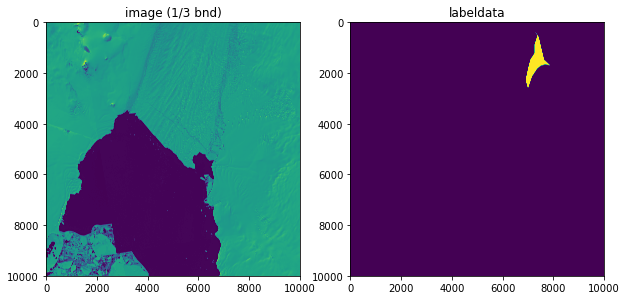

In [12]:
import matplotlib.pyplot as plt
# imshow(amask[0])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
ax2.imshow(m2mask[0])
ax1.imshow(bands[0,:,:]) 
ax2.set_title('labeldata');
ax1.set_title('image (1/3 bnd)');

### Convert Mask to integer and add as band to image

mask is boolean. Convert to integer representation true==1 false==0

convert mask to DataArray. import coordinates from bands

In [13]:
import xarray
amask= xarray.DataArray(data=m2mask,dims=['band','y','x'],coords={'band':[0],'y':bands[0].coords['y'],'x':bands[0].coords['x']})

In [14]:
from rioxarray.rioxarray import _add_attrs_proj
_add_attrs_proj(amask,bands[0])

<xarray.DataArray (band: 1, y: 10002, x: 10004)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 0
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [15]:
masked_image=xarray.concat([bands,amask],'band')
# masked_image

# Apply windowing function on image
(do not actually export windows, as we already ahve these. Just save the labeldata that correspond with each window)


In [16]:
from itertools import product
from rasterio import windows

def get_windows(src, overlap, width, height, boundless=True):
    offsets = product(range(0, src.meta['width'], width), range(0, src.meta['height'], height))
    full_window = windows.Window(col_off=0, row_off=0, width=src.meta['width'], height=src.meta['height'])
    for col_off, row_off in offsets:
        window = windows.Window(
            col_off=col_off - overlap,
            row_off=row_off - overlap,
            width=width,
            height=height)
        
        if boundless:
            yield window
        else:
            yield window.intersection(full_window)

Define window:

In [17]:
width = 20
height = 20
overlap = 5

source_data = dataPath+imName
print(source_data)

/Users/maaikeizeboud/Documents/Data/test/S2_comp_first.tif


#### Create window list:

In [18]:
import xarray as xr
with rasterio.open(source_data) as src:
    window_list = [w for w in get_windows(src, overlap, width, height)]
    arrays = [src.read([1, 2, 3], window=window, boundless=False) for window in window_list]

In [41]:
print(len(window_list), len(arrays) )

251001 251001


In [36]:
window_list[1:10]

[Window(col_off=-5, row_off=15, width=20, height=20),
 Window(col_off=-5, row_off=35, width=20, height=20),
 Window(col_off=-5, row_off=55, width=20, height=20),
 Window(col_off=-5, row_off=75, width=20, height=20),
 Window(col_off=-5, row_off=95, width=20, height=20),
 Window(col_off=-5, row_off=115, width=20, height=20),
 Window(col_off=-5, row_off=135, width=20, height=20),
 Window(col_off=-5, row_off=155, width=20, height=20),
 Window(col_off=-5, row_off=175, width=20, height=20)]

In [43]:
arrays[1]

array([[[ 9240,  9224,  9272,  9160,  9208,  9192,  9208,  9264,  9280,
          9304,  9240,  9312,  9352,  9288,  9376],
        [ 9416,  9512,  9304,  9240,  9208,  9184,  9184,  9192,  9168,
          9216,  9120,  9120,  9192,  9208,  9280],
        [ 9536,  9536,  9336,  9264,  9168,  9120,  9080,  9088,  9168,
          9168,  9032,  9032,  9120,  9104,  9128],
        [ 9544,  9640,  9472,  9440,  9408,  9232,  9088,  9120,  9096,
          9128,  9072,  9040,  9136,  9056,  9040],
        [ 9312,  9472,  9696,  9576,  9512,  9512,  9328,  9168,  9136,
          9096,  9128,  9128,  9008,  9112,  9056],
        [ 9304,  9472,  9656,  9408,  9480,  9544,  9328,  9328,  9368,
          9192,  9200,  9168,  8976,  9008,  9120],
        [ 9312,  9440,  9432,  9376,  9456,  9544,  9376,  9352,  9408,
          9368,  9376,  9376,  9312,  9232,  9176],
        [ 9440,  9384,  9376,  9376,  9512,  9512,  9304,  9208,  9304,
          9440,  9320,  9408,  9480,  9544,  9376],
        

In [59]:
arrays[0].shape
# plt.imshow(arrays[0][1,:,:])

(3, 15, 15)

In [21]:
import os
imPath = '/Users/maaikeizeboud/Documents/Data/tiles_test/'
imgs = sorted([file for file in os.listdir(imPath) if file.endswith('.tif') ]) # list with image names
len(imgs)

1000

#### Create same windowlist from masked image

In [46]:

source_data = dataPath+imName
with rasterio.open(source_data) as src:
    print(src.meta['width'],src.meta['height'])
    print(src.shape)
    print(type(src))
    
print(bands.shape, masked_image.shape)
print('check reading dimensions for eventual tile (is it square?):')

# source_data = '/Users/maaikeizeboud/Documents/Data/test/data_update_S2_composite_2019-11-1_2020-3-1_tile_0.tif'
# with rasterio.open(source_data) as src:
#     print(src.meta['width'],src.meta['height'])


10004 10002
(10002, 10004)
<class 'rasterio.io.DatasetReader'>
(3, 10002, 10004) (4, 10002, 10004)
check reading dimensions for eventual tile (is it square?):


In [28]:

def get_windows2(src, overlap, width, height, boundless=True):
    input_width = src.shape[2] # src has shape (bnds, X , Y)
    input_height = src.shape[1] # Which, when reading 'src.meta[width]' is (bands, height,width)
    
#     offsets = product(range(0, src.meta['width'], width), range(0, src.meta['height'], height))
    offsets = product(range(0, input_width, width), range(0, input_height, height))
    full_window = windows.Window(col_off=0, row_off=0, width=input_width, height=input_height)
    for col_off, row_off in offsets:
        window = windows.Window(
            col_off=col_off - overlap,
            row_off=row_off - overlap,
            width=width,
            height=height)
        
        if boundless:
            yield window
        else:
            yield window.intersection(full_window)

#### Use window_list reading to cut windows from masked_image 
-- gives error: as this uses rasterio.read(), and the masked_image is a xarray

In [55]:
# using window_list reading -- only for rasterio dataReader object

# src = masked_image
# window_list = [w for w in get_windows2(src, overlap, width, height)]
# len(window_list)
# arrays = [src.read([1, 2, 3], window=window, boundless=False) for window in window_list]

# using rolling window for xarray


#### Use xarray window rolling

In [68]:
# initialize rolling object 
rolling = bands.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [65]:

cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15}, # windwo_listing uses 'overlap' of 5, which is a stride of 15 for a window of 20pixels
)

In [66]:

cutouts.shape 

(3, 667, 667, 15, 15)

In [60]:
cutouts[0].shape

(667, 667, 20, 20)

In [67]:
len(cutouts[0])+len(cutouts[0])

1334

#### Exporting windows

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10004, 'height': 10002, 'count': 3, 'crs': CRS.from_wkt('LOCAL_CS["WGS 84 / Antarctic Polar Stereographic",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3031"]]'), 'transform': Affine(10.0, 0.0, -1653920.0,
       0.0, -10.0, -266650.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True}

In [ ]:

# with rasterio.open(source_data) as src:
#     def write_array(array, window, outpath):
#         profile = src.profile
#         profile.update(
#             transform=src.window_transform(window),
#             height=window.height,
#             width=window.width)
#         with rasterio.open(outpath, 'w', **profile) as dst:
#             dst.write(array)
    
#     with concurrent.futures.ThreadPoolExecutor(
#             max_workers=8
#         ) as executor:
#             futures = executor.map(write_array, arrays, window_list, outpath_list)